# Importing Libraries & BTC Stock

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

df = yf.download("BTC-USD", start="2018-01-01", end="2022-01-01", interval="1d")
df.dropna(inplace=True)
df.columns = df.columns.get_level_values(0)
df

/tmp/ipython-input-3439766479.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2018-01-01", end="2022-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2021-12-27,50640.417969,51956.328125,50499.468750,50802.609375,24324345758
2021-12-28,47588.855469,50679.859375,47414.210938,50679.859375,33430376883
2021-12-29,46444.710938,48119.742188,46201.496094,47623.871094,30049226299


# Strategy : Ichimoku Cloud + Fibonacci Retracement

In [2]:
# Ichimoku Cloud Calculation
def ichimoku_cloud(df):
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()

    df['Tenkan'] = (high_9 + low_9) / 2
    df['Kijun'] = (high_26 + low_26) / 2
    df['Senkou_A'] = ((df['Tenkan'] + df['Kijun']) / 2).shift(26)
    df['Senkou_B'] = ((high_52 + low_52) / 2).shift(26)
    df['Chikou'] = df['Close'].shift(-26)
    return df

# Fibonacci Retracement Levels
def fibonacci_levels(df):
    recent_low = df['Low'].min()
    recent_high = df['High'].max()
    diff = recent_high - recent_low

    levels = {
        '0.0%': recent_high,
        '23.6%': recent_high - 0.236 * diff,
        '38.2%': recent_high - 0.382 * diff,
        '50.0%': recent_high - 0.500 * diff,
        '61.8%': recent_high - 0.618 * diff,
        '78.6%': recent_high - 0.786 * diff,
        '100.0%': recent_low
    }
    return levels

# Generating Signals

In [3]:
# Signal Generation
def generate_signals(df, fib_levels, tolerance=0.01):
    signals = []

    for i in range(len(df)):
        row = df.iloc[i]
        price = row['Close']
        senkou_a = row['Senkou_A']
        senkou_b = row['Senkou_B']
        tenkan = row['Tenkan']
        kijun = row['Kijun']

        # Handling missing values
        if any(pd.isna([senkou_a, senkou_b, tenkan, kijun])):
            signals.append(0)
            continue

        cloud_top = max(float(senkou_a), float(senkou_b))
        cloud_bottom = min(float(senkou_a), float(senkou_b))

        near_support = any(abs(price - level)/price <= tolerance
                           for label, level in fib_levels.items() if float(label.strip('%')) > 50)
        near_resistance = any(abs(price - level)/price <= tolerance
                              for label, level in fib_levels.items() if float(label.strip('%')) < 50)

        if price > cloud_top or (tenkan > kijun and near_support):
            signal = 1
        elif price < cloud_bottom or (tenkan < kijun and near_resistance):
            signal = -1
        else:
            signal = 0

        signals.append(signal)

    df['Signal'] = signals
    return df

In [4]:
def plot1_ichimoku_fibonacci(df, fib_levels):
    plt.figure(figsize=(20, 10))

    plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
    plt.plot(df.index, df['Tenkan'], label='Conversion Line', color='blue', linewidth=0.8)
    plt.plot(df.index, df['Kijun'], label='Base Line', color='magenta', linewidth=0.8)
    plt.plot(df.index, df['Senkou_A'], label='Senkou A', color='green', linewidth=1)
    plt.plot(df.index, df['Senkou_B'], label='Senkou B', color='red', linewidth=1)

    plt.fill_between(df.index, df['Senkou_A'], df['Senkou_B'],
                     where=df['Senkou_A'] >= df['Senkou_B'], color='lightgreen', alpha=0.5)
    plt.fill_between(df.index, df['Senkou_A'], df['Senkou_B'],
                     where=df['Senkou_A'] < df['Senkou_B'], color='lightcoral', alpha=0.5)

    for label, level in fib_levels.items():
        plt.axhline(y=level, linestyle='--', alpha=0.7, label=f'Fib {label}')

    plt.title('BTC-USD Price with Ichimoku Cloud & Fibonacci Levels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot2_ichimoku_fibonacci(df, fib_levels):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df.index, y=df['Tenkan'], name='Tenkan', line=dict(color='green'),opacity=0.5))
    fig.add_trace(go.Scatter(x=df.index, y=df['Kijun'], name='Kijun', line=dict(color='red'),opacity=0.5))
    fig.add_trace(go.Scatter(x=df.index, y=df['Senkou_A'], name='Senkou A', line=dict(color='black'),opacity=0.5))
    fig.add_trace(go.Scatter(x=df.index, y=df['Senkou_B'], name='Senkou B', line=dict(color='orange'),opacity=0.5))

    buy = df[df["Signal"] == 1]
    sell = df[df['Signal'] == -1]

    fig.add_trace(go.Scatter(x=buy.index, y=buy['Close'], mode='markers', name='Buy', marker=dict(color='green', symbol='triangle-up', size=10)))
    fig.add_trace(go.Scatter(x=sell.index, y=sell['Close'], mode='markers', name='Sell', marker=dict(color='red', symbol='triangle-down', size=10)))
    for label, level in fib_levels.items():
        fig.add_trace(go.Scatter(
            x=[df.index[0], df.index[-1]],
            y=[level, level],
            mode='lines',
            line=dict(dash='dash', color='gray'),
            name=f'Fib {label}',
            opacity=0.7
        ))

    fig.update_layout(title='BTC-USD Price with Ichimoku Cloud & Fibonacci Levels')
    fig.show()

In [5]:
# Run indicators and generate signals
df = ichimoku_cloud(df)
fib_levels = fibonacci_levels(df)
df = generate_signals(df, fib_levels)
last_signal = 0

for i in range(len(df)):
    current = df.loc[df.index[i], 'Signal']
    if current != 0:
        if current == last_signal:
            df.loc[df.index[i], 'Signal'] = 0
        else:
            last_signal = current
df

Price,Close,High,Low,Open,Volume,Tenkan,Kijun,Senkou_A,Senkou_B,Chikou,Signal
Date,,,,,,,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000,NaN,NaN,NaN,NaN,11440.700195,0
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192,NaN,NaN,NaN,NaN,11786.299805,0
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160,NaN,NaN,NaN,NaN,11296.400391,0
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744,NaN,NaN,NaN,NaN,10106.299805,0
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072,NaN,NaN,NaN,NaN,10221.099609,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50640.417969,51956.328125,50499.468750,50802.609375,24324345758,48768.068359,50178.392578,58824.281250,61179.695312,NaN,0
2021-12-28,47588.855469,50679.859375,47414.210938,50679.859375,33430376883,48768.068359,50178.392578,58824.281250,61179.695312,NaN,0
2021-12-29,46444.710938,48119.742188,46201.496094,47623.871094,30049226299,49078.912109,48389.648438,58287.691406,60643.105469,NaN,0


# Including MACD for enhancing returns

In [6]:
# Adding MACD for better returns

def macd(df):
  df['6_day_EMA'] = df['Close'].ewm(span=12,adjust=False).mean()
  df['13_day_EMA'] = df['Close'].ewm(span=26,adjust=False).mean()
  df['MACD'] = df['6_day_EMA'] - df['13_day_EMA']
  df['signal_line'] = df['MACD'].ewm(span=4,adjust=False).mean()
  return df
df = macd(df)
signals = list(df['Signal'])
macd_signals = [0]
signal_line = list(df['signal_line'])
for i in range(1,len(df)):
  if signal_line[i-1] > 0 and signal_line[i] < 0:
    macd_signals.append(-1)
  elif signal_line[i-1] < 0 and signal_line[i] > 0:
    macd_signals.append(1)
  else:
    macd_signals.append(0)
final_signals = []
for i in range(len(df)):
  if signals[i] != macd_signals[i]:
    if signals[i] and macd_signals[i]:
      final_signals.append(signals[i])
    else:
      if signals[i]:
        final_signals.append(signals[i])
      else:
        final_signals.append(macd_signals[i])
  else:
    final_signals.append(signals[i])
df['Signal'] = final_signals

# Cleaning Signals

In [7]:
# Signal Cleaning
def clean_signals(df):
  signal = list(df['Signal'])
  current = 0
  for i in range(len(signal)):
    if current:
      if signal[i] and signal[i]!=current:
        current = signal[i]
      else:
        signal[i] = 0
    else:
      current = signal[i]
  df['Signal'] = signal
  return df
df = clean_signals(df)
n = len(df[df['Signal']!=0])
print(f'Number of signals genrated: {n}')

Number of signals genrated: 37


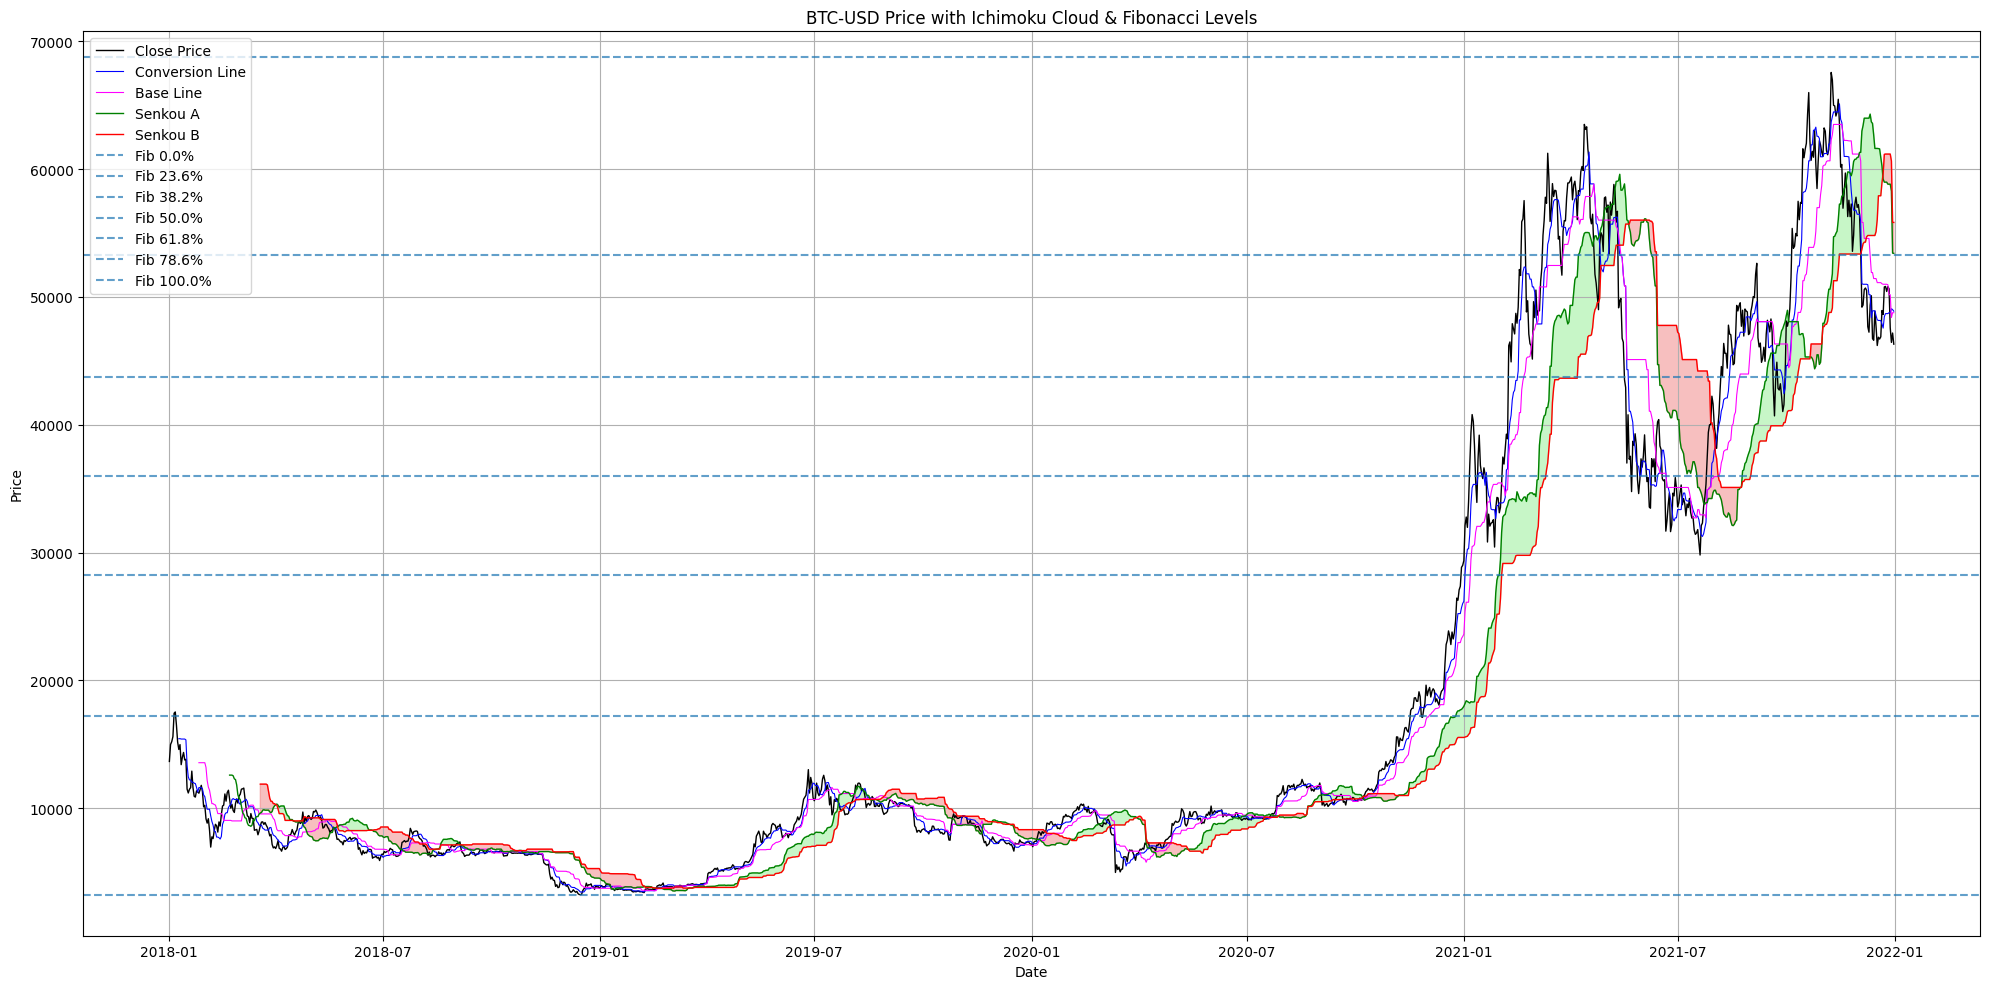

In [8]:
plot1_ichimoku_fibonacci(df, fib_levels)
plot2_ichimoku_fibonacci(df, fib_levels)

# Risk Management

In [9]:
def atr(df):
  high = list(df['High'])
  low = list(df['Low'])
  close = list(df['Close'])
  tr = [high[0] - low[0]]
  for i in range(1,len(df)):
    tr.append(max(high[i] - low[i],abs(high[i] - close[i-1]),abs(low[i] - close[i])))
  df['true_range'] = tr
  df['atr'] = df['true_range'].ewm(span=14,adjust=True).mean()
  del df['true_range']
  return df
df = atr(df)
buy_df = df[df['Signal'] == 1]
sell_df = df[df['Signal'] == -1]

fig=go.Figure()
fig.add_trace(go.Scatter(x=buy_df.index, y=buy_df['Close'], mode='markers', name='Buy', marker=dict(color='green', symbol='triangle-up', size=12)))
fig.add_trace(go.Scatter(x=sell_df.index, y=sell_df['Close'], mode='markers', name='Sell', marker=dict(color='red', symbol='triangle-down', size=12)))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['atr']*10, name='ATR', line=dict(color='orange'),opacity=0.5))

fig.show()

In [10]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(series, N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

# Backtesting

In [11]:
# Backtesting Engine

def backtest(df):
  opening_capital = 1000000
  capt = opening_capital
  signals = list(df['Signal'])
  close = list(df['Close'])
  no_of_trades = 0
  long_trades = 0
  winning_trades = 0
  atr = list(df['atr'])
  current_trade = 0
  entry_price = 0
  shares = 0
  no_of_buy_signals = len(df[df['Signal'] == 1])
  no_of_sell_signals = len(df[df['Signal'] == -1])
  portfolio_value = []
  ht = []
  entry_index = 0
  for i in range(len(df)):
    if current_trade:
      if current_trade == 1:
        if close[i] < (entry_price - atr[i]):
          capt+=(shares*(close[i] - entry_price))
          current_trade = 0
          shares = 0
          no_of_trades+=1
          long_trades+=1
          ht.append(i - entry_index)
        if current_trade:
          portfolio_value.append(capt+(shares*(close[i] - entry_price)))
        else:
          portfolio_value.append(capt)
      else:
        if close[i] > (entry_price + atr[i]):
          capt+=(shares*(entry_price - close[i]))
          current_trade = 0
          shares = 0
          no_of_trades+=1
          ht.append(i - entry_index)
        if current_trade:
          portfolio_value.append(capt+(shares*(entry_price - close[i])))
        else:
          portfolio_value.append(capt)
    else:
      portfolio_value.append(capt)
    if signals[i] == 1:
      if current_trade == -1:
        capt+=(shares*(entry_price - close[i]))
        if entry_price > close[i]:
          winning_trades+=1
        current_trade = 0
        shares = 0
        no_of_trades+=1
        ht.append(i - entry_index)
      if no_of_sell_signals > 0:
        current_trade = 1
        if atr[i] <= 2000:
          shares = int(capt/close[i])
        elif atr[i] > 2000 and atr[i] < 4000:
          shares = int(0.75*capt/close[i])
        else:
          shares = int(0.5*capt/close[i])
        entry_price = close[i]
        entry_index = i
      no_of_buy_signals-=1
    if signals[i] == -1:
      if current_trade == 1:
        capt+=(shares*(close[i] - entry_price))
        current_trade = 0
        shares = 0
        no_of_trades+=1
        long_trades+=1
        ht.append(i - entry_index)
        if close[i] > entry_price:
          winning_trades+=1
      if no_of_buy_signals > 0:
        current_trade = -1
        entry_price = close[i]
        if atr[i] <= 2000:
          shares = int(capt/close[i])
        elif atr[i] > 2000 and atr[i] < 4000:
          shares = int(0.75*capt/close[i])
        else:
          shares = int(0.5*capt/close[i])
        entry_index = i
      no_of_sell_signals-=1
  df['portfolio_value'] = portfolio_value
  dd = []
  peak = portfolio_value[0]
  for value in portfolio_value:
      if value > peak:
          peak = value
      drawdown = (peak - value) / peak
      dd.append(drawdown)

  max_drawdown = max(dd)
  average_drawdown = sum(dd) / len(dd)
  excess_returns = [0]
  for i in range(1,len(portfolio_value)):
    er = (portfolio_value[i] - portfolio_value[i-1])*100/portfolio_value[i-1]
    excess_returns.append(er)
  df['excess_returns'] = excess_returns
  sr1 = sharpe_ratio(df['excess_returns'],len(df),0.04)
  sr2 = sortino_ratio(df['excess_returns'],len(df),0.04)
  print(f'Benchmark Returns: {(close[len(df)-1] - close[0])*100/close[0]}%')
  print(f'Portfolio Returns: {(portfolio_value[len(df)-1] - portfolio_value[0])*100/portfolio_value[0]}%')
  print(f'Total trades executed: {no_of_trades}')
  print(f'Win rate: {winning_trades*100/no_of_trades}%')
  print(f'Total Long Trades: {long_trades}')
  print(f'Total Short Trades: {no_of_trades - long_trades}')
  print(f'Average Drawdown: -{average_drawdown*100}%')
  print(f'Max Drawdown: -{max_drawdown*100}%')
  print(f'Sharpe Ratio: {sr1}')
  print(f'Sortino Ratio: {sr2}')
  print(f'Average Holding Time: {sum(ht)/len(ht)} days')
  print(f'Maximum Holding Time: {max(ht)} days')
  print()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=df.index, y=df['portfolio_value'], name='Portfolio Value', line=dict(color='blue')))
  fig.update_layout(title='Portfolio Value')
  fig.show()

In [12]:
backtest(df)

Benchmark Returns: 239.0625065918969%
Portfolio Returns: 857.7857562255859%
Total trades executed: 36
Win rate: 33.333333333333336%
Total Long Trades: 18
Total Short Trades: 18
Average Drawdown: -25.116672026177223%
Max Drawdown: -46.95002349132768%
Sharpe Ratio: 2.5533530780271874
Sortino Ratio: 3.364869207564304
Average Holding Time: 32.44444444444444 days
Maximum Holding Time: 196 days

